In [15]:
def run_simulation(mode="Greedy", run_id=0, seed=42):
    import pandas as pd
    import random

    # Load card data
    track_df = pd.read_csv("tracks.csv").sample(n=12, random_state=seed + run_id).reset_index(drop=True)
    car_df = pd.read_csv("cars.csv")
    upgrade_df = pd.read_csv("upgrades.csv")

    NUM_PLAYERS = 12
    POINTS_BY_POSITION = [25, 18, 15, 12, 10, 8, 6, 4, 2, 1] + [0] * (NUM_PLAYERS - 10)

    players = [{"id": i + 1, "car": car_df.iloc[i], "points": 0} for i in range(NUM_PLAYERS)]
    player_upgrade_pool = {
        p["id"]: list(upgrade_df.sample(12, replace=True).to_dict(orient="records")) for p in players
    }

    simulation_results = []

    for track_index, track in track_df.iterrows():
        racers = []

        for player in players:
            car = player["car"]
            base_cp = car["Core Power"]
            base_ml = car["Max Laps"]
            available_upgrades = player_upgrade_pool[player["id"]]

            best_upgrade = None
            best_total_cp = -1
            best_total_ml = -1
            best_can_finish = False
            best_bonus_cp = 0
            best_bonus_ml = 0
            chosen_index = -1

            if mode == "Random":
                chosen_index = random.randint(0, len(available_upgrades) - 1)
                upgrade = available_upgrades[chosen_index]
                condition = upgrade["Track Type Condition"]
                valid = (
                    condition == "-" or pd.isna(condition)
                    or track["Track Type"] in [t.strip() for t in str(condition).split("/")]
                )
                upgrade_cp = upgrade["Core Power"] if valid else 0
                upgrade_ml = upgrade["Max Laps"] if valid else 0
                bonus_cp = 0
                bonus_ml = 0

                if track["Track Type"] in str(car["Track Type"]):
                    bonus_val, bonus_type = track["Type Bonus"].split(maxsplit=1)
                    bonus_val = int(bonus_val)
                    if "Core Power" in bonus_type:
                        bonus_cp += bonus_val
                    elif "Max Laps" in bonus_type:
                        bonus_ml += bonus_val

                best_upgrade = upgrade
                best_total_cp = base_cp + upgrade_cp + bonus_cp
                best_total_ml = base_ml + upgrade_ml + bonus_ml
                best_can_finish = best_total_ml >= track["Total Laps"]
                best_bonus_cp = bonus_cp
                best_bonus_ml = bonus_ml

            elif mode == "Greedy":
                for idx, upgrade in enumerate(available_upgrades):
                    upgrade_cp = upgrade["Core Power"]
                    upgrade_ml = upgrade["Max Laps"]
                    condition = upgrade["Track Type Condition"]
                    valid = (
                        condition == "-" or pd.isna(condition)
                        or track["Track Type"] in [t.strip() for t in str(condition).split("/")]
                    )
                    if not valid:
                        upgrade_cp = 0
                        upgrade_ml = 0

                    bonus_cp = 0
                    bonus_ml = 0
                    if track["Track Type"] in str(car["Track Type"]):
                        bonus_val, bonus_type = track["Type Bonus"].split(maxsplit=1)
                        bonus_val = int(bonus_val)
                        if "Core Power" in bonus_type:
                            bonus_cp += bonus_val
                        elif "Max Laps" in bonus_type:
                            bonus_ml += bonus_val

                    total_cp = base_cp + upgrade_cp + bonus_cp
                    total_ml = base_ml + upgrade_ml + bonus_ml
                    can_finish = total_ml >= track["Total Laps"]
                    score = total_cp + (10000 if can_finish else 0)

                    if score > best_total_cp + (10000 if best_can_finish else 0):
                        best_upgrade = upgrade
                        best_total_cp = total_cp
                        best_total_ml = total_ml
                        best_can_finish = can_finish
                        best_bonus_cp = bonus_cp
                        best_bonus_ml = bonus_ml
                        chosen_index = idx

            # Remove used upgrade
            del player_upgrade_pool[player["id"]][chosen_index]

            racers.append({
                "Run ID": run_id,
                "Mode": mode,
                "Player ID": player["id"],
                "Car": car["Car"],
                "Upgrade": best_upgrade["Upgrade"],
                "Track": track["Track"],
                "Track Type": track["Track Type"],
                "Total Laps": track["Total Laps"],
                "Core Power": best_total_cp,
                "Max Laps": best_total_ml,
                "Can Finish": best_can_finish,
            })

        finishers = sorted([r for r in racers if r["Can Finish"]], key=lambda x: x["Core Power"], reverse=True)
        non_finishers = sorted([r for r in racers if not r["Can Finish"]], key=lambda x: x["Core Power"], reverse=True)
        all_ranked = finishers + non_finishers

        for rank, r in enumerate(all_ranked):
            r["Rank"] = rank + 1
            r["Points Earned"] = POINTS_BY_POSITION[rank] if r["Can Finish"] else 0
            simulation_results.append(r)

    return pd.DataFrame(simulation_results)


In [16]:
import pandas as pd
greedy_runs = pd.concat([run_simulation(mode="Greedy", run_id=i) for i in range(1)], ignore_index=True)
random_runs = pd.concat([run_simulation(mode="Random", run_id=i) for i in range(1)], ignore_index=True)

# Combine both
all_results = pd.concat([greedy_runs, random_runs], ignore_index=True)

# Save if needed
all_results.to_csv("combined_simulation_results_1.csv", index=False)

# Average points per player by mode
avg_points = all_results.groupby(["Mode", "Player ID", "Car"]).agg({
    "Points Earned": "mean",
    "Can Finish": "mean",
    "Rank": "mean",
}).reset_index()

print(avg_points.head())

     Mode  Player ID     Car  Points Earned  Can Finish      Rank
0  Greedy          1  Car 01       9.916667    0.833333  5.583333
1  Greedy          2  Car 02      10.750000    0.666667  5.083333
2  Greedy          3  Car 03       7.250000    0.916667  6.500000
3  Greedy          4  Car 04       7.250000    0.583333  6.333333
4  Greedy          5  Car 05       7.750000    0.916667  6.333333


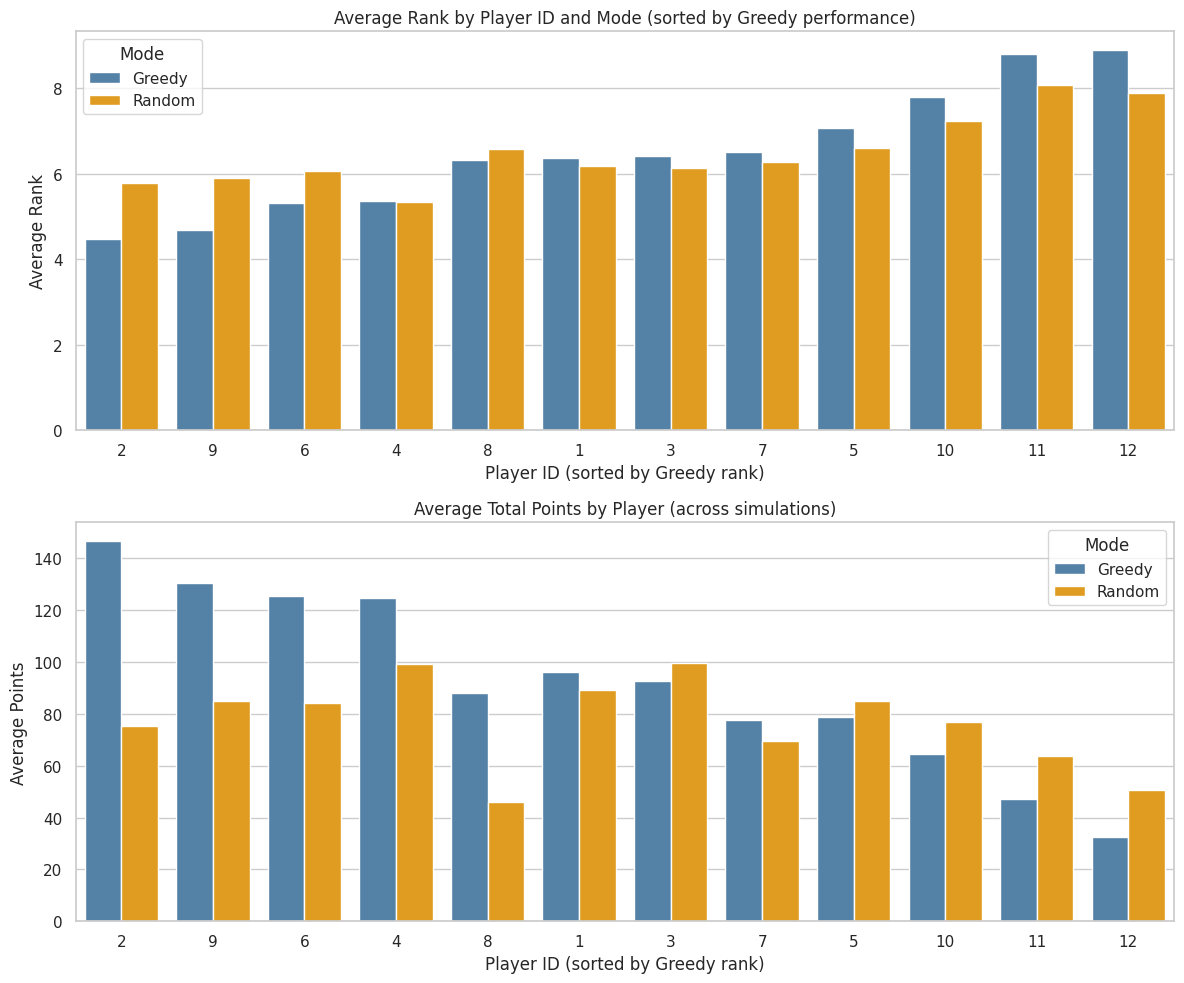

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load combined simulation results
df = pd.read_csv("combined_simulation_results_10.csv")
palette = {"Greedy": "steelblue", "Random": "orange"}

# === Average Rank per Player ===
avg_rank = df.groupby(["Mode", "Player ID"])["Rank"].mean().reset_index()

# === Average Total Points per Player ===
player_total_per_run = df.groupby(["Mode", "Run ID", "Player ID"])["Points Earned"].sum().reset_index()
avg_points = player_total_per_run.groupby(["Mode", "Player ID"])["Points Earned"].mean().reset_index()

# === Sort Player IDs by Greedy Rank ===
greedy_order = (
    avg_rank[avg_rank["Mode"] == "Greedy"]
    .sort_values("Rank")["Player ID"]
    .tolist()
)

# Apply order to both DataFrames
avg_rank["Player ID"] = pd.Categorical(avg_rank["Player ID"], categories=greedy_order, ordered=True)
avg_points["Player ID"] = pd.Categorical(avg_points["Player ID"], categories=greedy_order, ordered=True)

avg_rank = avg_rank.sort_values("Player ID")
avg_points = avg_points.sort_values("Player ID")

# === Create subplots (with sharex=False to keep both x-axes)
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=False)

# Top: Average Rank
sns.barplot(data=avg_rank, x="Player ID", y="Rank", hue="Mode", palette=palette, ax=axes[0])
axes[0].set_title("Average Rank by Player ID and Mode (sorted by Greedy performance)")
axes[0].set_xlabel("Player ID (sorted by Greedy rank)")
axes[0].set_ylabel("Average Rank")
axes[0].legend(title="Mode")
axes[0].tick_params(axis='x', rotation=0)  # Force tick labels to show

# Bottom: Average Points
sns.barplot(data=avg_points, x="Player ID", y="Points Earned", hue="Mode", palette=palette, ax=axes[1])
axes[1].set_title("Average Total Points by Player (across simulations)")
axes[1].set_xlabel("Player ID (sorted by Greedy rank)")
axes[1].set_ylabel("Average Points")
axes[1].legend(title="Mode")
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()


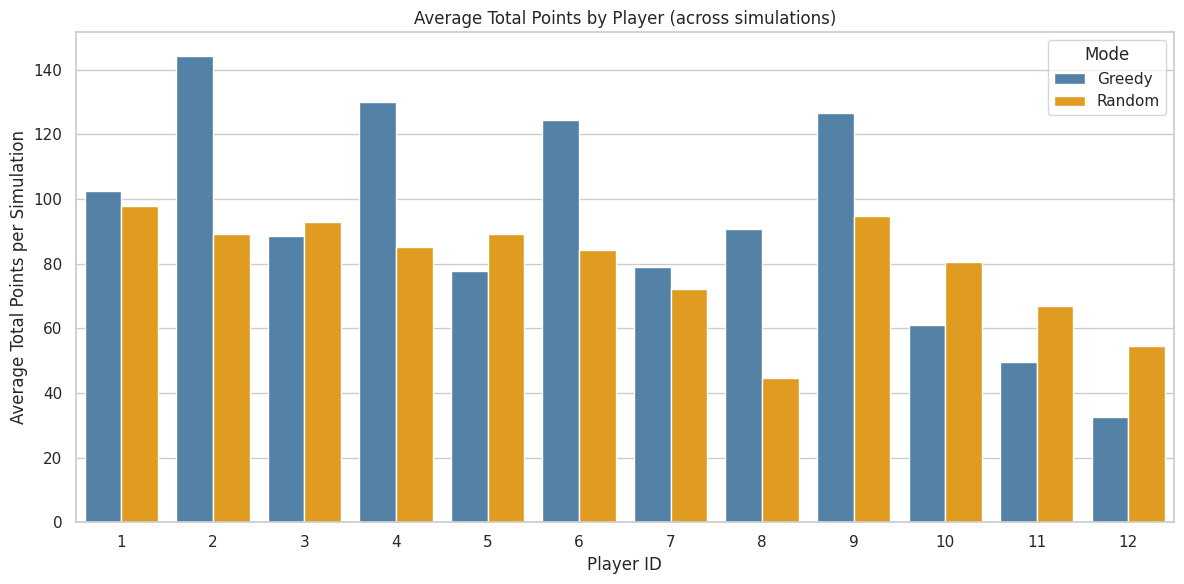

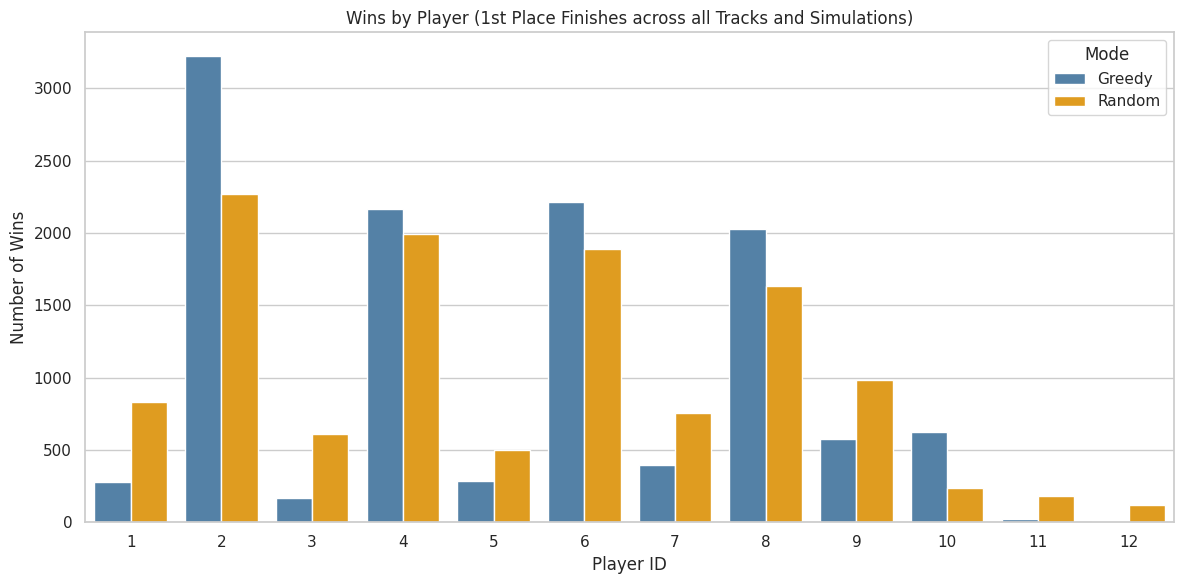

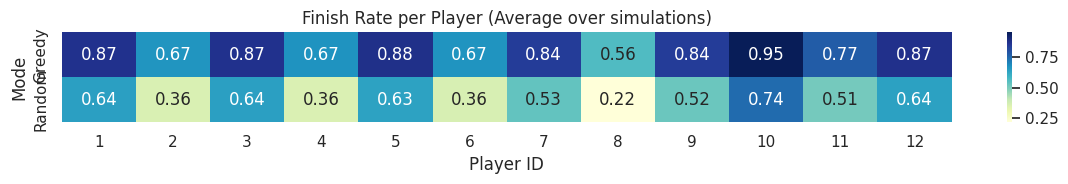

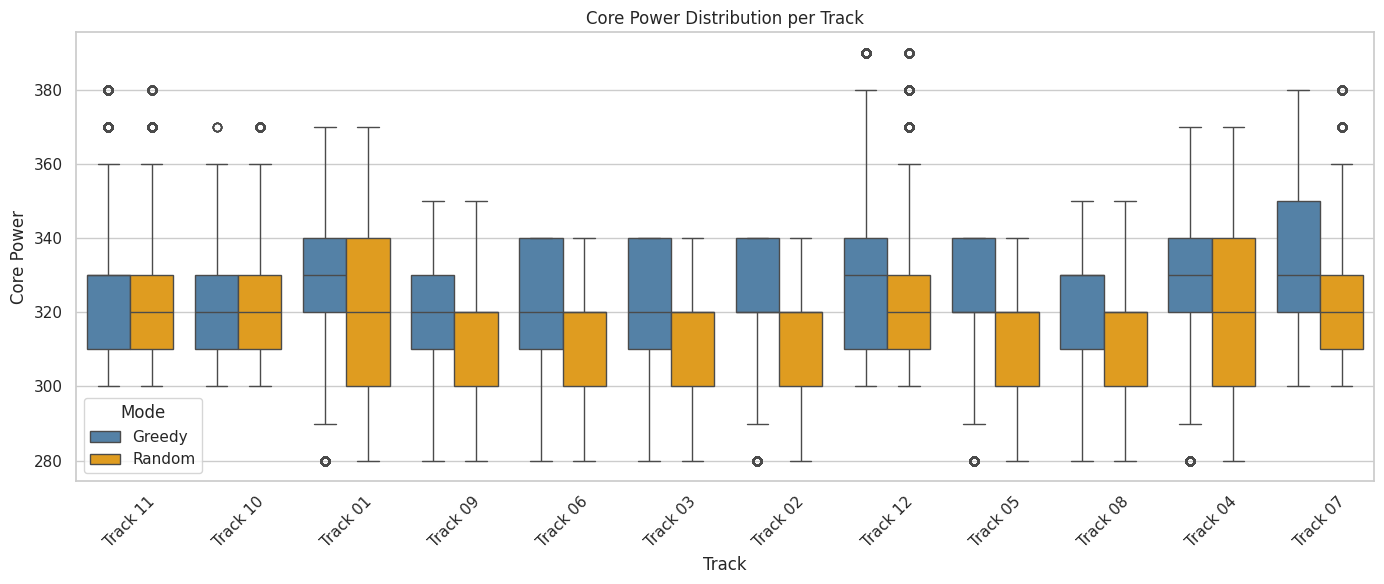

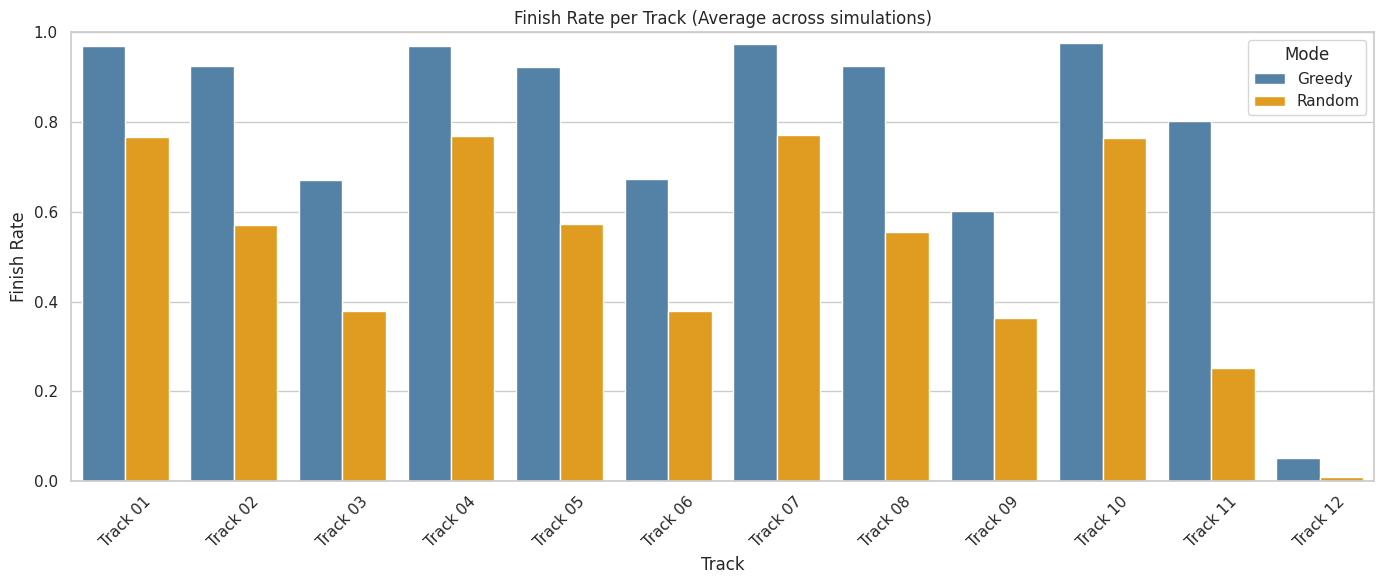

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load combined simulation results
df = pd.read_csv("combined_simulation_results_1000.csv")

# Set Seaborn style
sns.set(style="whitegrid")

# Consistent color palette: Greedy = Blue, Random = Orange
palette = {"Greedy": "steelblue", "Random": "orange"}

# ======================
# 1. Average Total Points by Player (across simulations)
# ======================
player_total_per_run = df.groupby(["Mode", "Run ID", "Player ID"])["Points Earned"].sum().reset_index()
avg_points_per_player = player_total_per_run.groupby(["Mode", "Player ID"])["Points Earned"].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(data=avg_points_per_player, x="Player ID", y="Points Earned", hue="Mode", palette=palette)
plt.title("Average Total Points by Player (across simulations)")
plt.xlabel("Player ID")
plt.ylabel("Average Total Points per Simulation")
plt.legend(title="Mode")
plt.tight_layout()
plt.show()

# ======================
# 2. Wins (1st Place Finishes) by Player (across all tracks/simulations)
# ======================
wins = df[df["Rank"] == 1].groupby(["Mode", "Player ID"]).size().reset_index(name="Wins")

plt.figure(figsize=(12, 6))
sns.barplot(data=wins, x="Player ID", y="Wins", hue="Mode", palette=palette)
plt.title("Wins by Player (1st Place Finishes across all Tracks and Simulations)")
plt.xlabel("Player ID")
plt.ylabel("Number of Wins")
plt.legend(title="Mode")
plt.tight_layout()
plt.show()

# ======================
# 3. Finish Rate Heatmap (One row per Mode)
# ======================
finish_rate = df.groupby(["Mode", "Player ID"])["Can Finish"].mean().reset_index()
finish_pivot = finish_rate.pivot(index="Mode", columns="Player ID", values="Can Finish")
finish_pivot = finish_pivot[sorted(finish_pivot.columns)]

plt.figure(figsize=(12, 2))
sns.heatmap(finish_pivot, cmap="YlGnBu", annot=True, fmt=".2f", cbar=True)
plt.title("Finish Rate per Player (Average over simulations)")
plt.xlabel("Player ID")
plt.ylabel("Mode")
plt.tight_layout()
plt.show()

# ======================
# 4. Core Power Distribution per Track
# ======================
plt.figure(figsize=(14, 6))
sns.boxplot(data=df, x="Track", y="Core Power", hue="Mode", palette=palette)
plt.xticks(rotation=45)
plt.title("Core Power Distribution per Track")
plt.xlabel("Track")
plt.ylabel("Core Power")
plt.legend(title="Mode")
plt.tight_layout()
plt.show()

# ======================
# 5. Finish Rate per Track (Normalized View)
# ======================
finish_percent = (
    df.groupby(["Mode", "Track"])["Can Finish"]
    .mean()
    .reset_index()
    .rename(columns={"Can Finish": "Finish Rate"})
)

plt.figure(figsize=(14, 6))
sns.barplot(data=finish_percent, x="Track", y="Finish Rate", hue="Mode", palette=palette)
plt.xticks(rotation=45)
plt.title("Finish Rate per Track (Average across simulations)")
plt.xlabel("Track")
plt.ylabel("Finish Rate")
plt.ylim(0, 1.0)
plt.tight_layout()
plt.show()


## Extra Analysis per simulation
---

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Files and their sizes
files = {
    "1": "combined_simulation_results_1.csv",
    "10": "combined_simulation_results_10.csv",
    "100": "combined_simulation_results_100.csv",
    "1000": "combined_simulation_results_1000.csv"
}

# Consistent color palette
palette = {"Greedy": "steelblue", "Random": "orange"}

# Leaderboard generation function
def generate_leaderboard(df, mode):
    df_mode = df[df["Mode"] == mode]

    # Total Points per player
    total_points = df_mode.groupby(["Player ID", "Car"])["Points Earned"].sum().reset_index(name="Total Points")

    # Average Rank
    avg_rank = df_mode.groupby("Player ID")["Rank"].mean().reset_index(name="Avg Rank")

    # Wins (1st Place Finishes)
    wins = df_mode[df_mode["Rank"] == 1].groupby("Player ID").size().reset_index(name="Wins")

    # Finishes
    finishes = df_mode[df_mode["Can Finish"] == True].groupby("Player ID").size().reset_index(name="Finishes")

    # Merge all
    leaderboard = total_points.merge(avg_rank, on="Player ID").merge(wins, on="Player ID", how="left").merge(finishes, on="Player ID", how="left")
    leaderboard["Wins"] = leaderboard["Wins"].fillna(0).astype(int)
    leaderboard["Finishes"] = leaderboard["Finishes"].fillna(0).astype(int)

    # Rank by Total Points
    leaderboard["Rank"] = leaderboard["Total Points"].rank(method="min", ascending=False).astype(int)

    return leaderboard

# Store all results
all_leaderboards = []

# Loop over files
for sim_size, filename in files.items():
    df = pd.read_csv(filename)
    for mode in ["Greedy", "Random"]:
        lb = generate_leaderboard(df, mode)
        lb["Simulation Size"] = int(sim_size)
        lb["Mode"] = mode
        all_leaderboards.append(lb)

# Combine everything
leaderboard_df = pd.concat(all_leaderboards, ignore_index=True)
leaderboard_df_sorted = leaderboard_df.sort_values(by=["Mode", "Simulation Size", "Rank"])
leaderboard_df_sorted.head(12)

,Player ID,Car,Total Points,Avg Rank,Wins,Finishes,Rank,Simulation Size,Mode
1,2,Car 02,129,5.083333,2,8,1,1,Greedy
8,9,Car 09,126,4.750000,0,11,2,1,Greedy
5,6,Car 06,121,5.666667,3,8,3,1,Greedy
0,1,Car 01,119,5.583333,1,10,4,1,Greedy
7,8,Car 08,113,6.166667,4,6,5,1,Greedy
4,5,Car 05,93,6.333333,0,11,6,1,Greedy
2,3,Car 03,87,6.500000,0,11,7,1,Greedy
3,4,Car 04,87,6.333333,1,7,7,1,Greedy
6,7,Car 07,81,6.250000,0,10,9,1,Greedy
10,11,Car 11,59,8.666667,1,10,10,1,Greedy


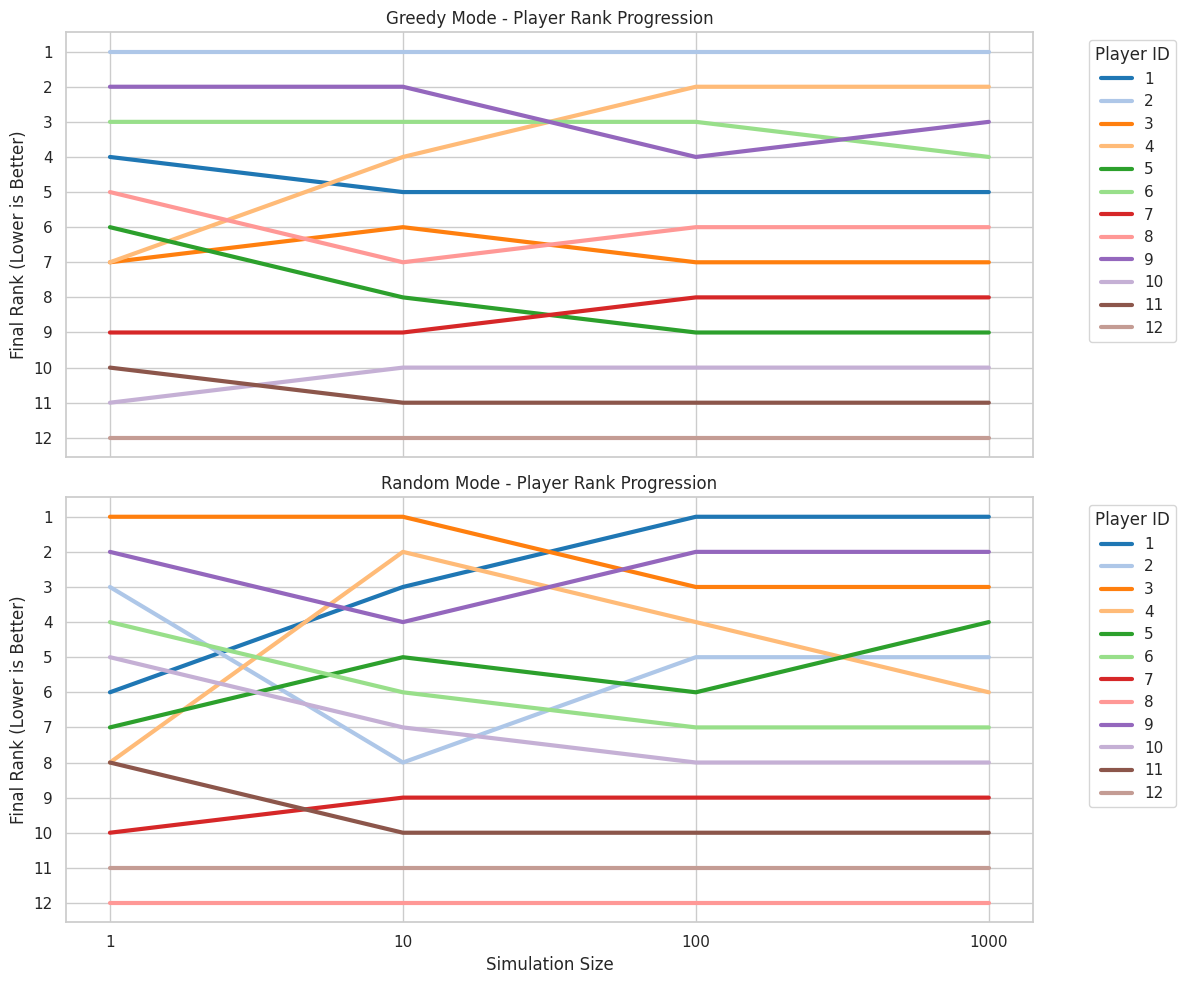

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure Simulation Size is string for spacing and labeling
leaderboard_df["Simulation Size"] = leaderboard_df["Simulation Size"].astype(str)

# Get consistent colors for each Player ID
player_ids = sorted(leaderboard_df["Player ID"].unique())
player_palette = dict(zip(player_ids, sns.color_palette("tab20", len(player_ids))))

# Create subplots for Greedy and Random
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Define common y-ticks (1 to 12)
yticks = list(range(1, 13))

# Plot for Greedy
sns.lineplot(
    data=leaderboard_df[leaderboard_df["Mode"] == "Greedy"],
    x="Simulation Size",
    y="Rank",
    hue="Player ID",
    palette=player_palette,
    ax=axes[0],
    linewidth=3
)
axes[0].set_title("Greedy Mode - Player Rank Progression")
axes[0].set_ylabel("Final Rank (Lower is Better)")
axes[0].invert_yaxis()
axes[0].set_yticks(yticks)
axes[0].grid(True)
axes[0].legend(title="Player ID", bbox_to_anchor=(1.05, 1), loc="upper left")

# Plot for Random
sns.lineplot(
    data=leaderboard_df[leaderboard_df["Mode"] == "Random"],
    x="Simulation Size",
    y="Rank",
    hue="Player ID",
    palette=player_palette,
    ax=axes[1],
    linewidth=3
)
axes[1].set_title("Random Mode - Player Rank Progression")
axes[1].set_xlabel("Simulation Size")
axes[1].set_ylabel("Final Rank (Lower is Better)")
axes[1].invert_yaxis()
axes[1].set_yticks(yticks)
axes[1].grid(True)
axes[1].legend(title="Player ID", bbox_to_anchor=(1.05, 1), loc="upper left")

# Improve spacing
plt.tight_layout()
plt.show()


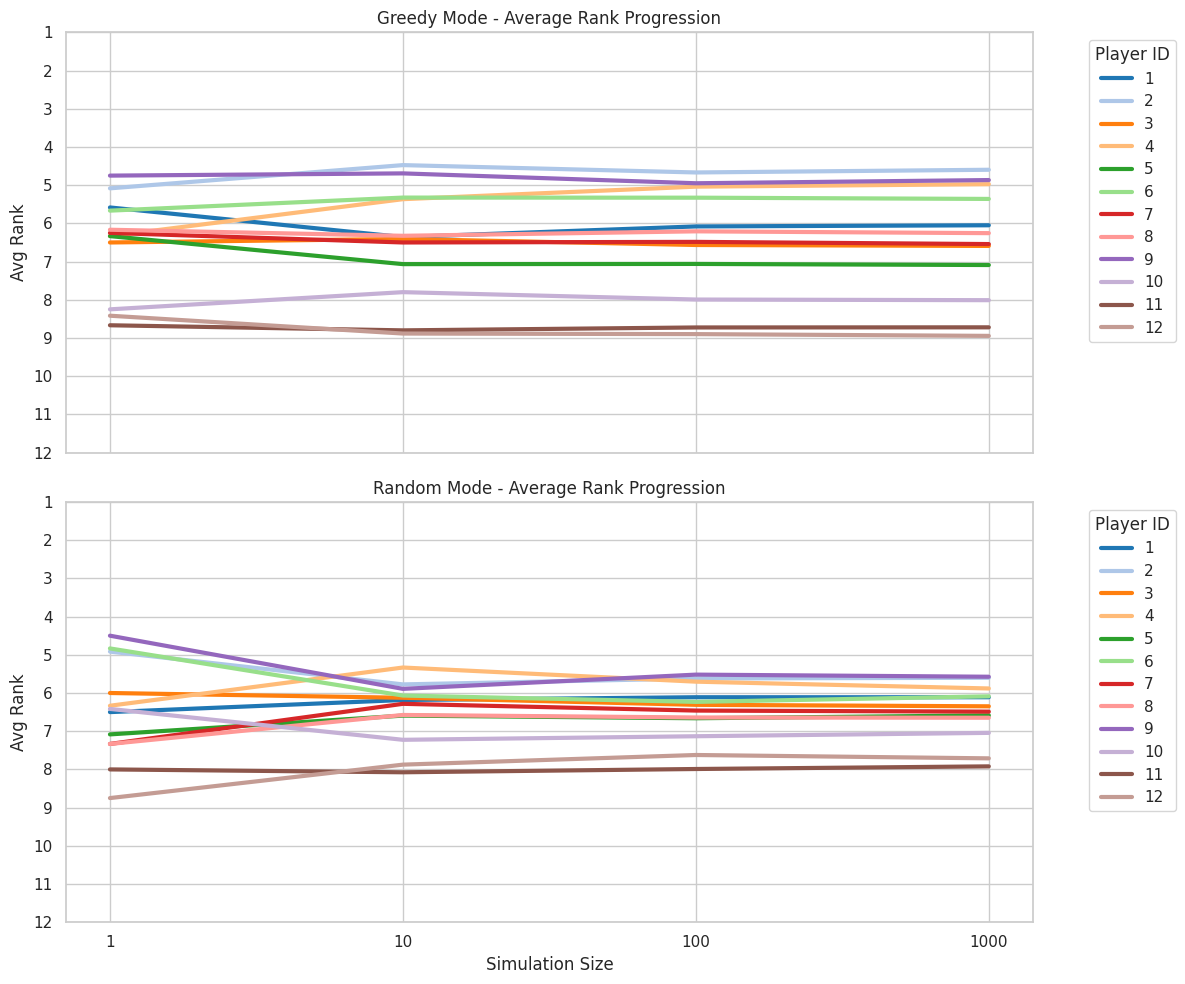

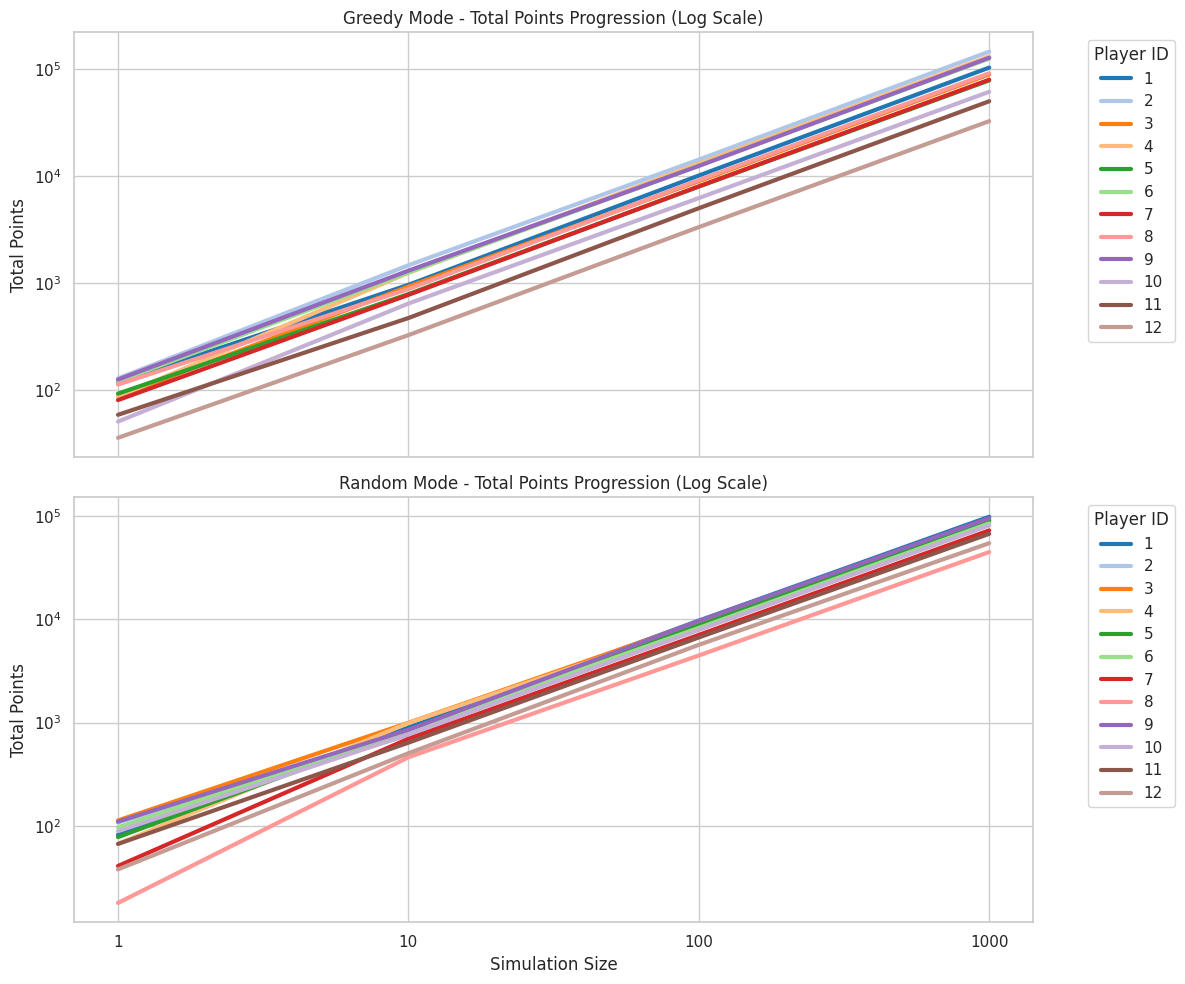

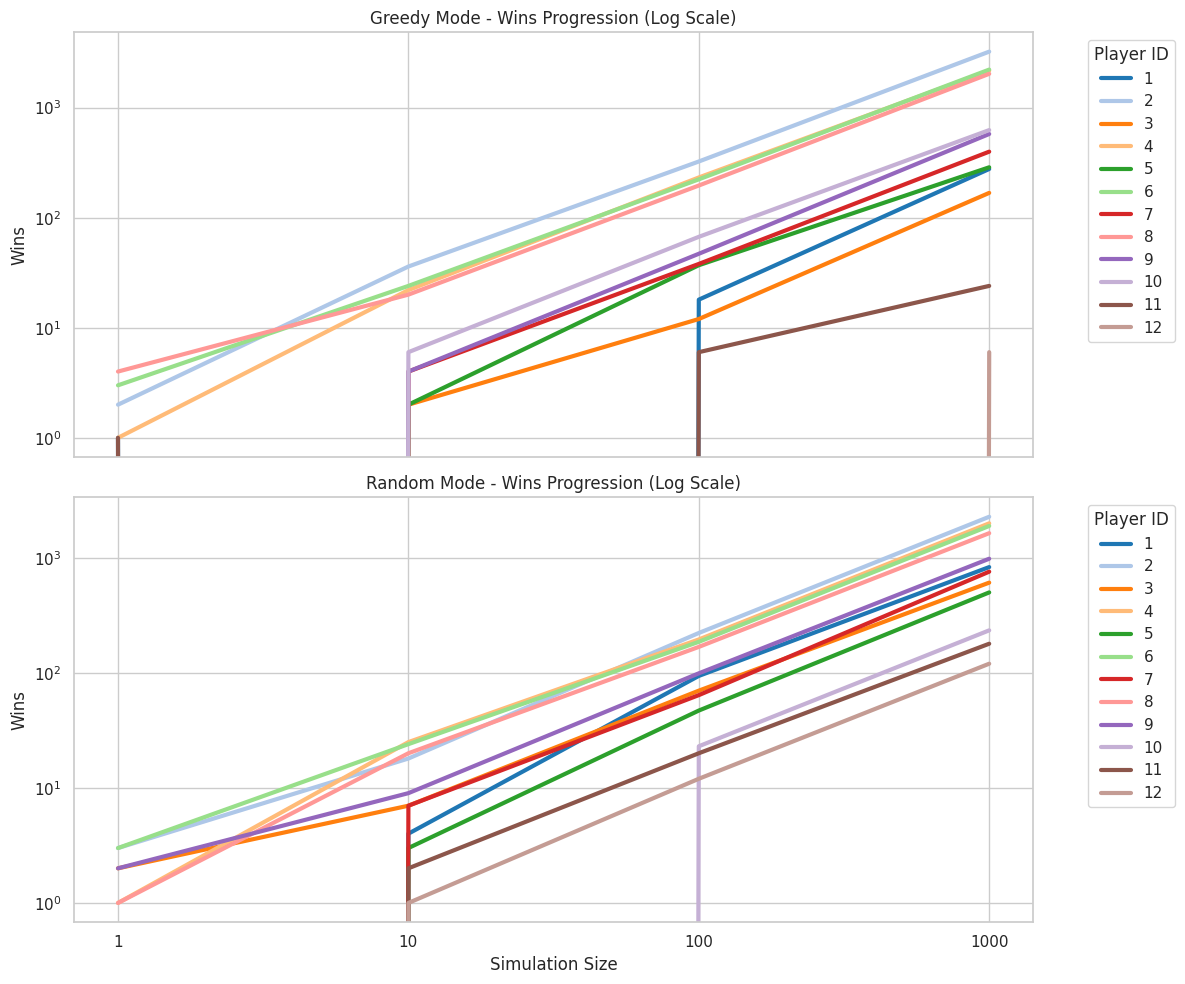

🏁 Final Greedy Leaderboard:
     Player ID     Car  Total Points  Avg Rank  Wins  Finishes  Rank  \
73          2  Car 02        144387  4.596917  3226      7998     1   
75          4  Car 04        130139  4.973750  2169      8054     2   
80          9  Car 09        126580  4.866333   576     10093     3   
77          6  Car 06        124614  5.360167  2216      8014     4   
72          1  Car 01        102494  6.049667   277     10430     5   
79          8  Car 08         90721  6.255750  2028      6763     6   
74          3  Car 03         88572  6.590333   168     10441     7   
78          7  Car 07         78991  6.541583   398     10081     8   
76          5  Car 05         77886  7.090083   287     10500     9   
81         10  Car 10         60946  8.010083   625     11423    10   
82         11  Car 11         49723  8.720750    24      9260    11   
83         12  Car 12         32424  8.944583     6     10462    12   

   Simulation Size    Mode  
73            1000

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure Simulation Size is string for plotting
leaderboard_df["Simulation Size"] = leaderboard_df["Simulation Size"].astype(str)

# Consistent player colors
player_ids = sorted(leaderboard_df["Player ID"].unique())
player_palette = dict(zip(player_ids, sns.color_palette("tab20", len(player_ids))))

# -------------------------------------
# 1. 📈 Avg Rank Progression
# -------------------------------------
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
yticks = list(range(1, 13))

# Greedy
sns.lineplot(
    data=leaderboard_df[leaderboard_df["Mode"] == "Greedy"],
    x="Simulation Size", y="Avg Rank",
    hue="Player ID", palette=player_palette, ax=axes[0], linewidth=3
)
axes[0].set_title("Greedy Mode - Average Rank Progression")
axes[0].set_ylabel("Avg Rank")
axes[0].invert_yaxis()
axes[0].set_yticks(yticks)
axes[0].grid(True)
axes[0].legend(title="Player ID", bbox_to_anchor=(1.05, 1), loc="upper left")

# Random
sns.lineplot(
    data=leaderboard_df[leaderboard_df["Mode"] == "Random"],
    x="Simulation Size", y="Avg Rank",
    hue="Player ID", palette=player_palette, ax=axes[1], linewidth=3
)
axes[1].set_title("Random Mode - Average Rank Progression")
axes[1].set_xlabel("Simulation Size")
axes[1].set_ylabel("Avg Rank")
axes[1].invert_yaxis()
axes[1].set_yticks(yticks)
axes[1].grid(True)
axes[1].legend(title="Player ID", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.show()

# -------------------------------------
# 2. 📈 Total Points Progression (Log)
# -------------------------------------
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Greedy
sns.lineplot(
    data=leaderboard_df[leaderboard_df["Mode"] == "Greedy"],
    x="Simulation Size", y="Total Points",
    hue="Player ID", palette=player_palette, ax=axes[0], linewidth=3
)
axes[0].set_title("Greedy Mode - Total Points Progression (Log Scale)")
axes[0].set_ylabel("Total Points")
axes[0].set_yscale("log")
axes[0].grid(True)
axes[0].legend(title="Player ID", bbox_to_anchor=(1.05, 1), loc="upper left")

# Random
sns.lineplot(
    data=leaderboard_df[leaderboard_df["Mode"] == "Random"],
    x="Simulation Size", y="Total Points",
    hue="Player ID", palette=player_palette, ax=axes[1], linewidth=3
)
axes[1].set_title("Random Mode - Total Points Progression (Log Scale)")
axes[1].set_xlabel("Simulation Size")
axes[1].set_ylabel("Total Points")
axes[1].set_yscale("log")
axes[1].grid(True)
axes[1].legend(title="Player ID", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.show()

# -------------------------------------
# 3. 📈 Wins Progression (Log)
# -------------------------------------
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Greedy
sns.lineplot(
    data=leaderboard_df[leaderboard_df["Mode"] == "Greedy"],
    x="Simulation Size", y="Wins",
    hue="Player ID", palette=player_palette, ax=axes[0], linewidth=3
)
axes[0].set_title("Greedy Mode - Wins Progression (Log Scale)")
axes[0].set_ylabel("Wins")
axes[0].set_yscale("log")
axes[0].grid(True)
axes[0].legend(title="Player ID", bbox_to_anchor=(1.05, 1), loc="upper left")

# Random
sns.lineplot(
    data=leaderboard_df[leaderboard_df["Mode"] == "Random"],
    x="Simulation Size", y="Wins",
    hue="Player ID", palette=player_palette, ax=axes[1], linewidth=3
)
axes[1].set_title("Random Mode - Wins Progression (Log Scale)")
axes[1].set_xlabel("Simulation Size")
axes[1].set_ylabel("Wins")
axes[1].set_yscale("log")
axes[1].grid(True)
axes[1].legend(title="Player ID", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.show()

# -------------------------------------
# 4. Final Leaderboards (Exported)
# -------------------------------------
final_greedy = leaderboard_df[(leaderboard_df["Simulation Size"] == "1000") & (leaderboard_df["Mode"] == "Greedy")].sort_values("Rank")
print("🏁 Final Greedy Leaderboard:\n", final_greedy)
final_greedy.to_csv("final_greedy_leaderboard_1000.csv", index=False)

final_random = leaderboard_df[(leaderboard_df["Simulation Size"] == "1000") & (leaderboard_df["Mode"] == "Random")].sort_values("Rank")
print("🏁 Final Random Leaderboard:\n", final_random)
final_random.to_csv("final_random_leaderboard_1000.csv", index=False)
